In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline  

from scipy import stats
from sklearn import preprocessing
from sklearn import feature_selection
import warnings
warnings.filterwarnings('ignore')
SEED = 44

In [2]:
train = pd.read_csv('house/train.csv')
test = pd.read_csv('house/test.csv')
print ("Data is loaded!")

Data is loaded!


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    return all_data.loc[:1459], all_data.loc[1460:]

df_train = pd.read_csv('house/train.csv')
y_train = df_train.SalePrice
id_val = df_train.Id
df_test = pd.read_csv('house/test.csv')
df_all = concat_df(df_train, df_test).drop(['SalePrice', 'Id'], axis=1)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print(f'Number of Training Examples = {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}\n')
print(f'Training X Shape = {df_train.shape}')
print(f'Training y Shape = {df_train["SalePrice"].shape[0]}\n')
print(f'Test X Shape = {df_test.shape}')
print(f'Test y Shape = {df_test.shape[0]}\n')
print(df_train.columns)

Number of Training Examples = 1460
Number of Test Examples = 1459

Training X Shape = (1460, 81)
Training y Shape = 1460

Test X Shape = (1459, 80)
Test y Shape = 1459

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 

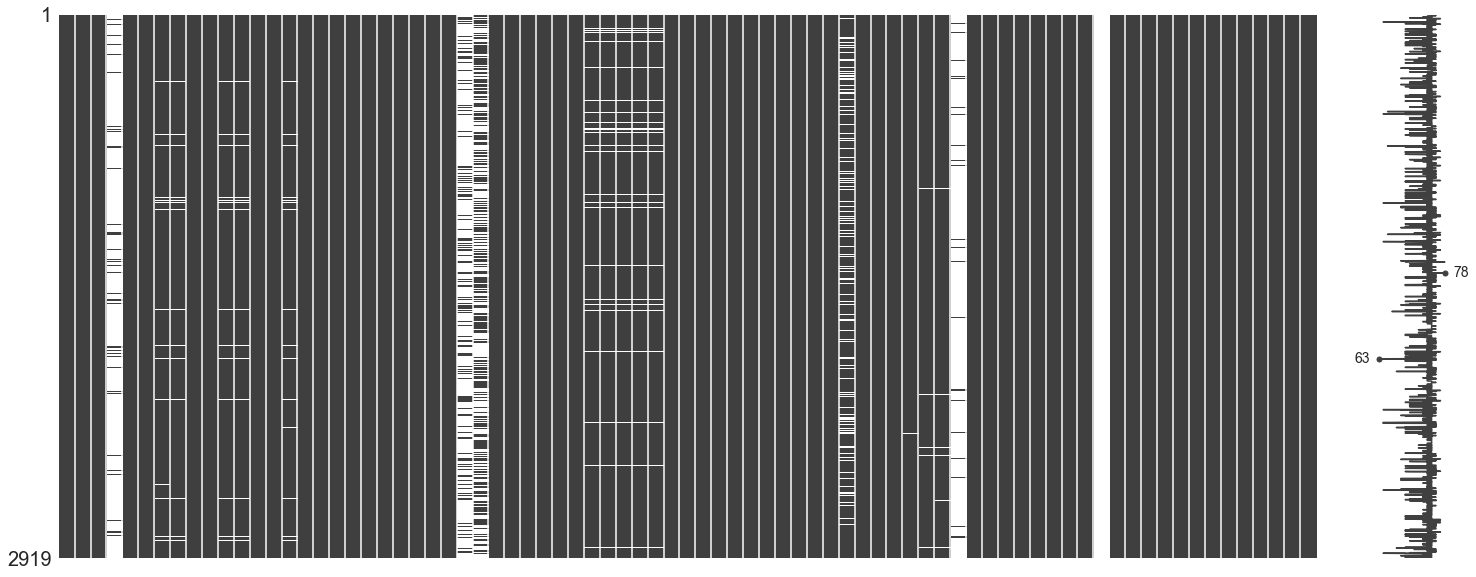

In [6]:
msno.matrix(df_all)
plt.show()

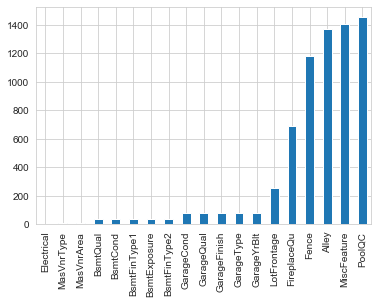

In [7]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

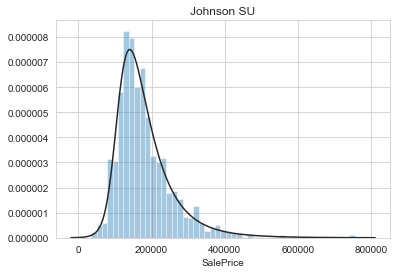

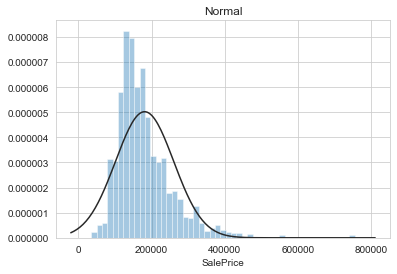

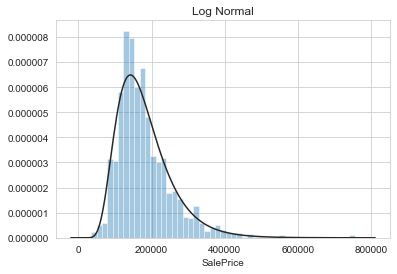

In [8]:
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [9]:
for df in dfs:
    print(f'Only features contained missing value in {df.name}')
    temp = df.isnull().sum()
    print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Set
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64 

Only features contained missing value in Test Set
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76

In [10]:
null_features = df_all.isnull().sum()
null_100 = df_all.columns[list((null_features < 100) & (null_features != 0))]
num = df_all[null_100].select_dtypes(include=np.number).columns
non_num = df_all[null_100].select_dtypes(include='object').columns
df_all[num] = df_all[num].apply(lambda x: x.fillna(x.median()))
df_all[non_num] = df_all[non_num].apply(lambda x: x.fillna(x.value_counts().index[0]))
null_1000 = df_all.columns[list(null_features > 1000)]
df_all.drop(null_1000, axis=1, inplace=True)
df_all.drop(['GarageYrBlt', 'LotFrontage'], axis=1, inplace=True)

In [11]:
df_all['GarageCond'] = df_all['GarageCond'].fillna('Null')
df_all['GarageFinish'] = df_all['GarageFinish'].fillna('Null')
df_all['GarageQual'] = df_all['GarageQual'].fillna('Null')
df_all['GarageType'] = df_all['GarageType'].fillna('Null')

In [12]:
df_train, df_test = divide_df(df_all)
df_train = pd.concat([df_train, y_train], axis=1)
if (df_all.isnull().any().sum()) == 0:
    print('No any missing values in dataset. В датасете нет отсутствующих значений, можно продолжать.')
else:
    print('DATASET HAVE MISSING VALUES.')

No any missing values in dataset. В датасете нет отсутствующих значений, можно продолжать.


In [13]:
df_train_corr = df_train.corr()['SalePrice'].sort_values(ascending=False).drop(['SalePrice'])
df_train_corr.head(10)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

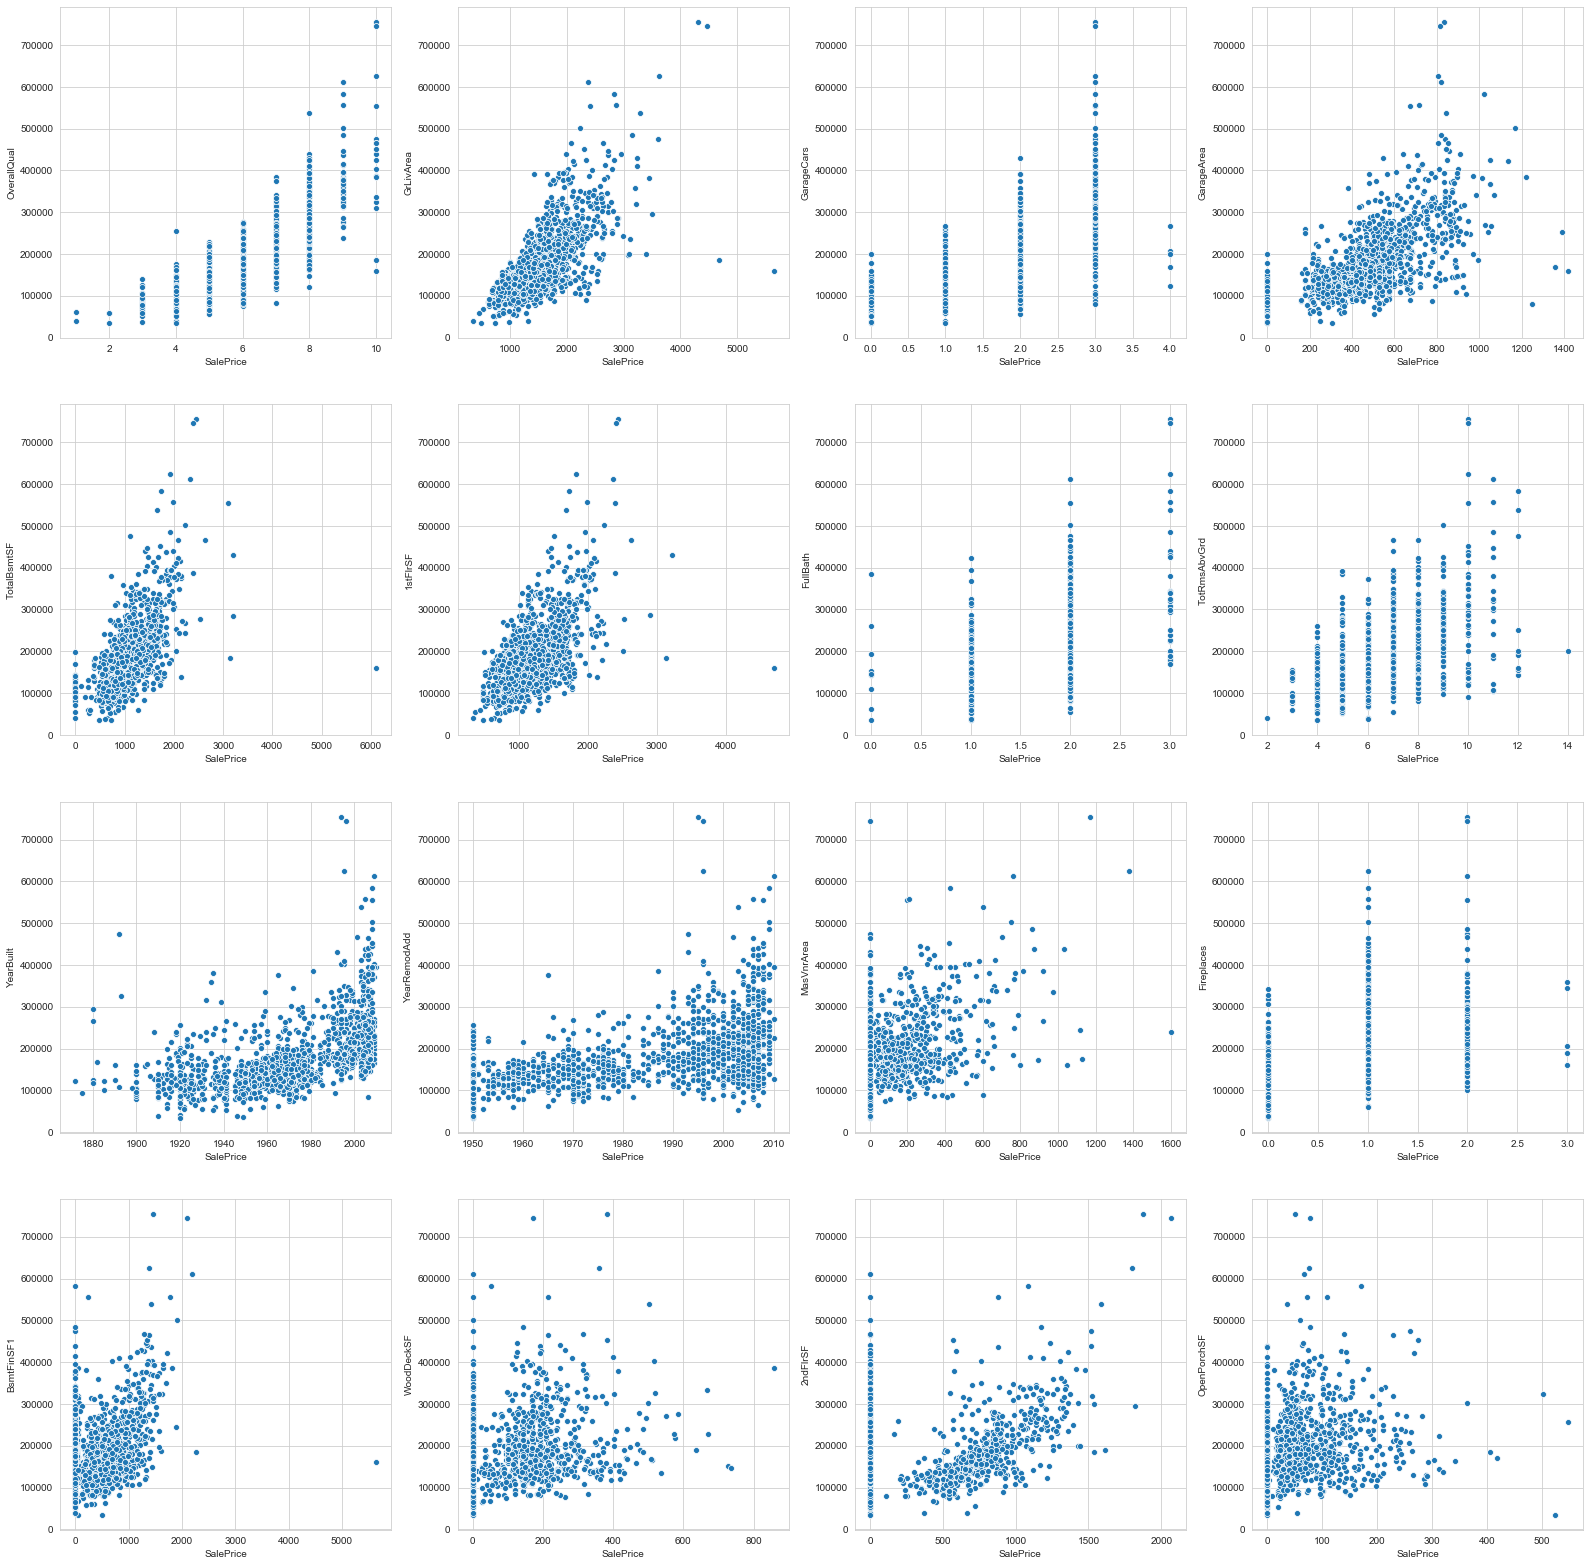

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(18, 18))
plt.subplots_adjust(right=1.3, top=1.3)
axs = axs.flatten()
for i, col in enumerate(list(df_train_corr.index[:16])):
    sns.scatterplot(y='SalePrice', x=col, ax=axs[i], data=df_train)
    axs[i].set_xlabel('SalePrice')
    axs[i].set_ylabel(col)
plt.show()

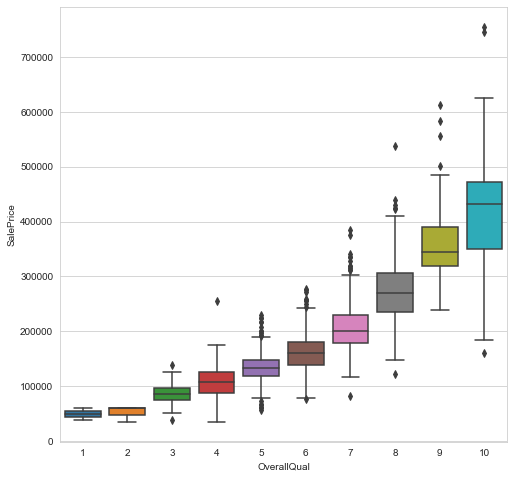

In [15]:
fig = plt.figure(figsize=(8, 8))
sns.boxplot(df_train['OverallQual'], df_train['SalePrice'])
plt.show()

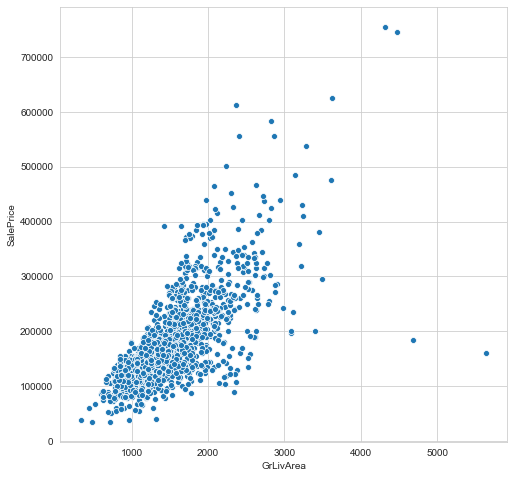

In [16]:
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(df_train['GrLivArea'], df_train['SalePrice'])
plt.show()

In [17]:
df_train_cate = df_train.select_dtypes(include=['object', 'category'])
df_train_cate.head()

,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
0,1Fam,TA,No,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
1,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,SBrkr,...,RL,None,Veenker,Y,CompShg,Gable,Normal,WD,Pave,AllPub
2,1Fam,TA,Mn,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
3,1Fam,Gd,No,ALQ,Unf,TA,Y,Norm,Norm,SBrkr,...,RL,None,Crawfor,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub
4,1Fam,TA,Av,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,NoRidge,Y,CompShg,Gable,Normal,WD,Pave,AllPub


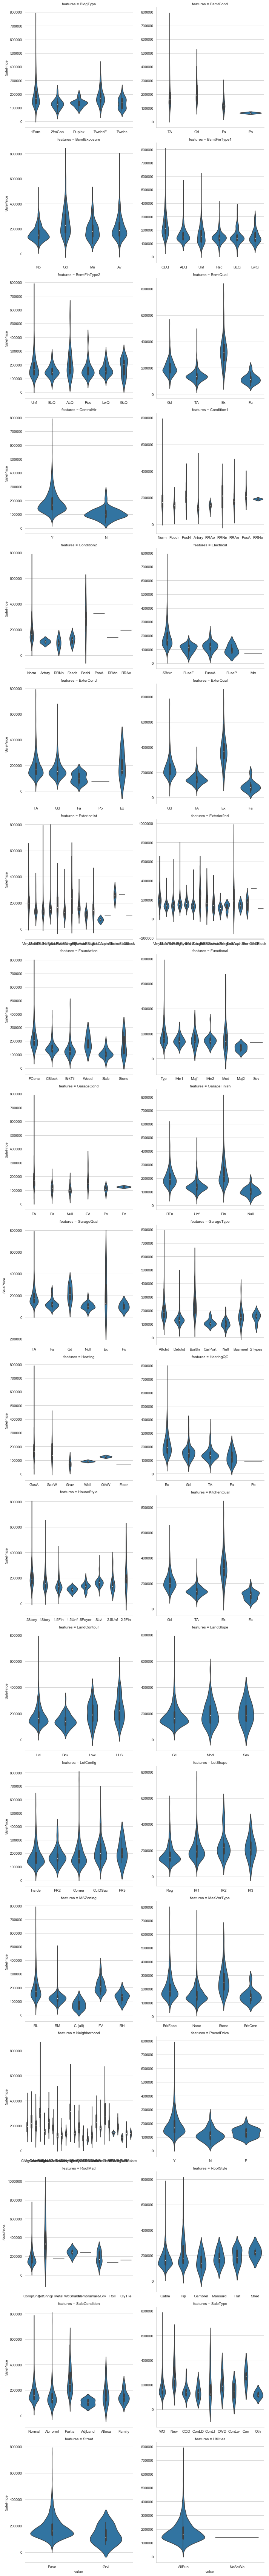

In [18]:
data = pd.melt(pd.concat([df_train_cate, y_train], axis=1),
               id_vars=['SalePrice'], value_vars=df_train_cate.columns, var_name='features')
g = sns.FacetGrid(data, col='features', col_wrap=2, sharex=False, sharey=False, size=5)
g.map(sns.violinplot, 'value', 'SalePrice')

In [19]:
df_train.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,346.992466,3.409589,2.866438,443.639726,46.549315,0.425342,0.057534,567.240411,21.954110,...,6.099315,2.758904,15.060959,6.517808,1057.429452,94.244521,1971.267808,1984.865753,2007.815753,180921.195890
std,386.587738,436.528436,29.317331,0.815778,456.098091,161.319273,0.518911,0.238753,441.866955,61.119149,...,1.382997,40.177307,55.757415,1.625393,438.705324,125.338794,30.202904,20.645407,1.328095,79442.502883
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000,34900.000000
25%,882.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,223.000000,0.000000,...,5.000000,0.000000,0.000000,5.000000,795.750000,0.000000,1954.000000,1967.000000,2007.000000,129975.000000
50%,1087.000000,0.000000,0.000000,3.000000,383.500000,0.000000,0.000000,0.000000,477.500000,0.000000,...,6.000000,0.000000,0.000000,6.000000,991.500000,0.000000,1973.000000,1994.000000,2008.000000,163000.000000
75%,1391.250000,728.000000,0.000000,3.000000,712.250000,0.000000,1.000000,0.000000,808.000000,0.000000,...,7.000000,0.000000,0.000000,7.000000,1298.250000,168.000000,2000.000000,2004.000000,2009.000000,214000.000000
max,4692.000000,2065.000000,508.000000,8.000000,5644.000000,1474.000000,3.000000,2.000000,2336.000000,552.000000,...,10.000000,738.000000,480.000000,14.000000,6110.000000,857.000000,2010.000000,2010.000000,2010.000000,755000.000000


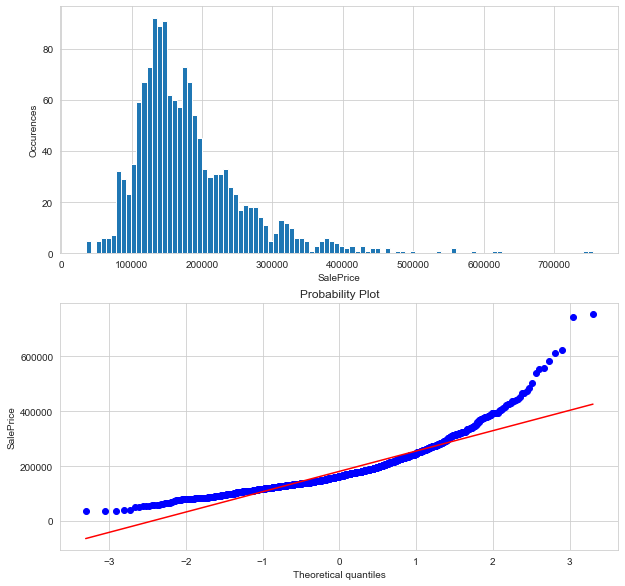

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
y_train.hist(bins=100, ax=ax1)
ax1.set_ylabel('Occurences')
ax1.set_xlabel('SalePrice')

stats.probplot(y_train, dist=stats.norm, plot=ax2)
ax2.set_ylabel('SalePrice')
plt.show()

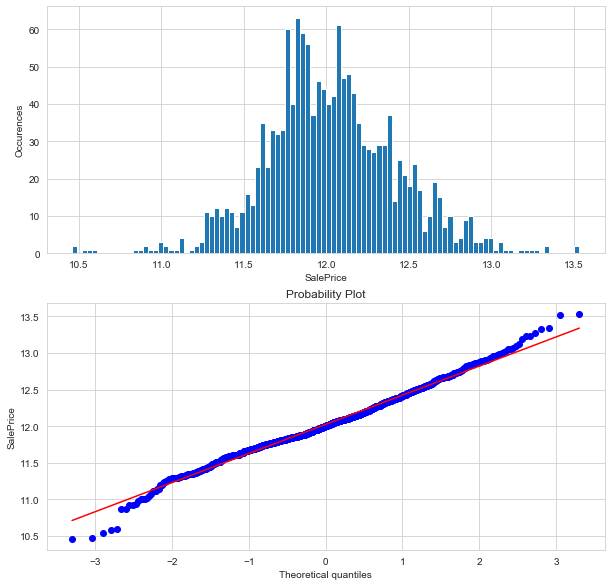

In [21]:
org_y_train = y_train
y_train = pd.Series(stats.boxcox(y_train, lmbda=0), name='SalePrice')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
y_train.hist(bins=100, ax=ax1)
ax1.set_ylabel('Occurences')
ax1.set_xlabel('SalePrice')

stats.probplot(y_train, dist=stats.norm, plot=ax2)
ax2.set_ylabel('SalePrice')
plt.show()

In [22]:
print(f'Skewness before transformation: {stats.skew(org_y_train)}')
print(f'Kurtosis before transformation: {stats.kurtosis(org_y_train)}\n')

print(f'Skewness after transformation: {stats.skew(y_train)}')
print(f'Kurtosis after transformation: {stats.kurtosis(y_train)}')

Skewness before transformation: 1.880940746034036
Kurtosis before transformation: 6.509812011089439

Skewness after transformation: 0.1212103673013655
Kurtosis after transformation: 0.8026555069117713


In [23]:
df_all['YearBuilt'] = pd.qcut(df_all['YearBuilt'], 10, duplicates='drop')
df_all['YearRemodAdd'] = pd.qcut(df_all['YearRemodAdd'], 10, duplicates='drop')
df_all['YrSold'] = pd.qcut(df_all['YrSold'], 10, duplicates='drop')

In [24]:
for cate_col in ['YearBuilt', 'YearRemodAdd', 'YrSold']:
    df_all[cate_col] = preprocessing.LabelEncoder().fit_transform(df_all[cate_col].values)

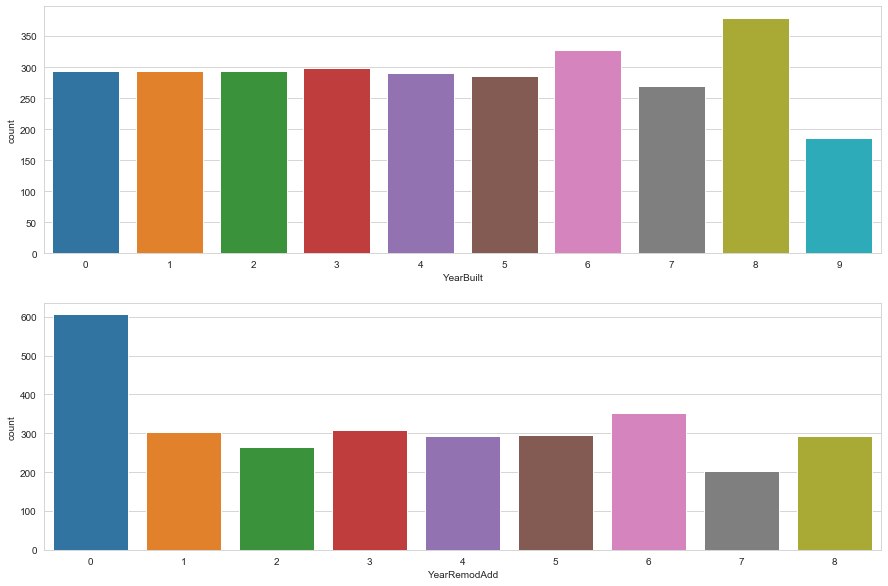

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
sns.countplot(df_all['YearBuilt'], ax=axs[0])
sns.countplot(df_all['YearRemodAdd'], ax=axs[1])
plt.show()

In [26]:
df_all['MSSubClass'] = df_all['MSSubClass'].astype(str)
df_all['OverallCond'] = df_all['OverallCond'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

In [27]:
df_all['TotalSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

df_all['TotalBath'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) +
                               df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))
df_all['TotalBsmtbath'] = df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath'])

df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                            df_all['EnclosedPorch'] + df_all['ScreenPorch'] + df_all['WoodDeckSF'])

df_all['IsRemodel'] = df_all[['YearBuilt', 'YearRemodAdd']].apply(lambda x: 1 if x[0] != x[1] else 0, axis=1)
df_all['HasPool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['Has2ndFloor'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasGarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasBsmt'] = df_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasFireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [28]:
remove_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'FullBath', 'HalfBath', 'BsmtFullBath',
              'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']
df_all.drop(remove_cols, axis=1, inplace=True)

In [29]:
cate_features = list(df_all.select_dtypes(include=['object', 'category']).columns)

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = list(df_all.select_dtypes(include=numeric_dtypes).columns)

In [30]:
df_train, df_test = divide_df(df_all)

In [31]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [32]:
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [33]:
def forward_feature_selection(df_train, cate_features):
    pre_ffs = pd.DataFrame(columns=cate_features)

    for cate_col in cate_features:
        pre_ffs[cate_col] = preprocessing.LabelEncoder().fit_transform(df_train[cate_col].values)
        
    sfs1 = SFS(RandomForestRegressor(),
               k_features=2,
               forward=True,
               floating=False,
               verbose=2,
               scoring='r2',
               cv=3)
    
    sfs1 = sfs1.fit(np.array(pre_ffs[cate_features]), np.array(y_train))
    return sfs1

In [34]:
cate_features =  ['BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
 'ExterCond', 'ExterQual', 'Exterior2nd', 'Functional', 'GarageCond', 'GarageType', 'Heating', 'HouseStyle', 'KitchenQual',
 'LandContour', 'LandSlope', 'LotShape', 'MSSubClass', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle',
 'SaleCondition', 'SaleType', 'Street', 'Utilities']

In [35]:
print('In training dataset\n', df_train['Electrical'].value_counts(), '\n')
print('In testing dataset\n', df_test['Electrical'].value_counts())

In training dataset
 SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64 

In testing dataset
 SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64


In [36]:
cate_mismatch = list()

for cate_col in cate_features:
    train_cate = df_train[cate_col].value_counts().index
    test_cate = df_test[cate_col].value_counts().index
    check_len = len(np.setdiff1d(train_cate, test_cate)) + len(np.setdiff1d(test_cate, train_cate))
    if check_len != 0:
        cate_mismatch.append(cate_col)
        
print('List of mismatched value features: \n', cate_mismatch)

List of mismatched value features: 
 ['Condition2', 'Electrical', 'Exterior2nd', 'Heating', 'HouseStyle', 'MSSubClass', 'RoofMatl', 'Utilities']


In [37]:

df_train['Electrical'].loc[df_train['Electrical']=='Mix'] = 'SBrkr'

df_train['Exterior2nd'].loc[df_train['Exterior2nd']=='Other'] = 'VinylSd'

df_train['Heating'].loc[df_train['Heating']=='OthW'] = 'GasA'
df_train['Heating'].loc[df_train['Heating']=='Floor'] = 'GasA'

df_train['HouseStyle'].loc[df_train['HouseStyle']=='2.5Fin'] = '1.5Fin'

df_test['MSSubClass'].loc[df_test['MSSubClass']=='150'] = '160'

temp = [True if ((val=='RRNn') | (val=='RRAn') | (val=='RRAe')) else False
        for val in df_train['Condition2']]
df_train['Condition2'].loc[temp] = 'Norm'
cate_drop = ['Utilities', 'RoofMatl']
df_train.drop(cate_drop, axis=1, inplace=True)
df_test.drop(cate_drop, axis=1, inplace=True)

cate_features = [col for col in cate_features if col not in cate_drop]

In [38]:
print('In training dataset\n', df_train['Electrical'].value_counts(), '\n')
print('In testing dataset\n', df_test['Electrical'].value_counts())

In training dataset
 SBrkr    1336
FuseA      94
FuseF      27
FuseP       3
Name: Electrical, dtype: int64 

In testing dataset
 SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64


In [39]:
pearson = dict()
for col in num_features:
    pear_val = stats.pearsonr(np.array(df_train[col]), np.array(y_train))[0]
    pearson[col] = pear_val
    
pearson = pd.Series(pearson).abs().sort_values(ascending=False)
num_features = list(pearson.loc[pearson > 0.2].index)
num_features

['OverallQual',
 'GrLivArea',
 'TotalSF',
 'GarageCars',
 'TotalBath',
 'GarageArea',
 'YearBuilt',
 'TotalBsmtSF',
 '1stFlrSF',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'HasFireplace',
 'Fireplaces',
 'MasVnrArea',
 'TotalPorchSF',
 'HasGarage',
 '2ndFlrSF',
 'LotArea',
 'TotalBsmtbath',
 'BsmtUnfSF',
 'BedroomAbvGr']

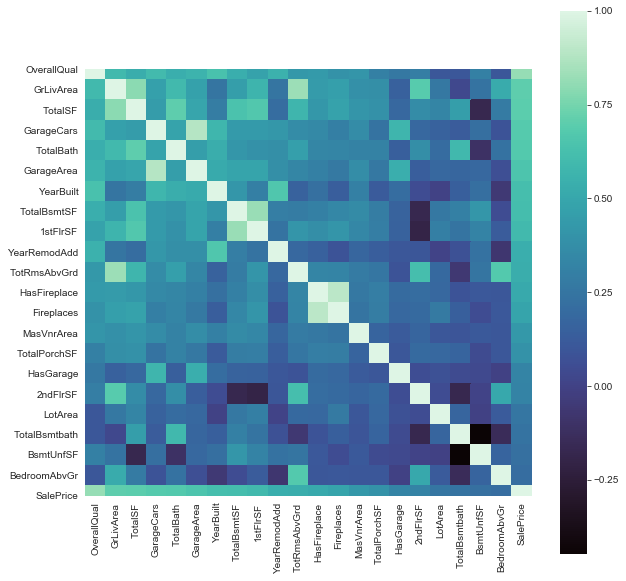

In [40]:
chosen_cols = num_features + cate_features

fig = plt.figure(figsize=(10, 10))
sns.heatmap(pd.concat([df_train[chosen_cols], y_train], axis=1).corr(), square=True,
            cmap='mako', annot_kws={'size': 14})

In [41]:
df_train = df_train[chosen_cols]
df_test = df_test[chosen_cols]
df_all = concat_df(df_train, df_test)

In [42]:
skew_features = df_all[num_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features = skew_features[abs(skew_features) > 0.75]
print(skew_features)           

for feat in skew_features.index:
    df_all[feat] = np.log1p(df_all[feat])

LotArea         12.822431
MasVnrArea       2.613592
TotalSF          1.835745
1stFlrSF         1.469604
TotalPorchSF     1.376649
GrLivArea        1.269358
TotalBsmtSF      1.162616
BsmtUnfSF        0.919703
2ndFlrSF         0.861675
TotRmsAbvGrd     0.758367
HasGarage       -3.955907
dtype: float64


In [43]:
df_train, df_test = divide_df(df_all)

In [44]:
print(df_train.shape, df_test.shape)

(1460, 48) (1459, 48)


In [45]:
encoded_features = list()

for df in [df_train, df_test]:
    for feature in cate_features:
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
df_train = pd.concat([df_train, *encoded_features[:len(cate_features)]], axis=1)
df_test = pd.concat([df_test, *encoded_features[len(cate_features):]], axis=1)

In [46]:
df_train.drop(cate_features, axis=1, inplace=True)
df_test.drop(cate_features, axis=1, inplace=True)

df_all = concat_df(df_train, df_test)

In [47]:
print(df_train.shape, df_test.shape)

(1460, 196) (1459, 196)


In [48]:
df_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtUnfSF,Fireplaces,GarageArea,GarageCars,GrLivArea,HasFireplace,HasGarage,...,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleType_9,Street_1,Street_2
0,6.753438,6.751101,3,5.017280,0,548.0,2.0,7.444833,0,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,7.141245,0.000000,3,5.652489,1,460.0,2.0,7.141245,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,6.825460,6.765039,3,6.075346,1,608.0,2.0,7.488294,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,6.869014,6.629363,3,6.293419,1,642.0,3.0,7.448916,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,7.044033,6.960348,4,6.196444,1,836.0,3.0,7.695758,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [49]:
from sklearn.model_selection import KFold # for repeated K-fold cross validation
from sklearn.model_selection import cross_val_score # score evaluation
from sklearn.model_selection import cross_val_predict # prediction
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import time
SEED = 44

In [50]:

kfolds = KFold(n_splits=10, shuffle=True, random_state=SEED)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def evaluate_model_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [51]:
def construct_models():

    alphas_ridge = [0.005, 0.01, 0.1, 1, 5, 10, 15]
    alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
    e_alphas_elas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
    e_l1ratio_elas = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
    

    models = dict()
    
    models['ridge'] = RidgeCV(alphas=alphas_ridge, cv=kfolds)
    models['lasso'] = LassoCV(alphas=alphas_lasso, random_state=SEED, cv=kfolds)
    models['elasticnet'] = ElasticNetCV(alphas=e_alphas_elas, cv=kfolds, l1_ratio=e_l1ratio_elas)
    models['svr'] = SVR(C = 20, epsilon = 0.008, gamma =0.0003)
    models['gbr'] = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10, 
                                              loss='huber',random_state =SEED) 
    models['lgbm'] = LGBMRegressor(objective='regression', num_leaves=4,
                                   learning_rate=0.01, n_estimators=5000,
                                   max_bin=200, bagging_fraction=0.75,
                                   bagging_freq=5, bagging_seed=7,
                                   feature_fraction=0.2,
                                   feature_fraction_seed=7, verbose=-1,
                                  colsample_bytree=None, subsample=None, subsample_freq=None)
    models['xgboost'] = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7, verbosity = 0,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=SEED, reg_alpha=0.00006)
    return models


models = construct_models()

In [52]:
for name, model in models.items():

    start = time.perf_counter()
    
    model = model.fit(np.array(df_train), np.array(y_train))
    rmse_result = rmse(y_train, model.predict(np.array(df_train)))
    print(f'{name}\'s rmse after training: {rmse_result}')
    
    # Compute time for executing each algo
    run = time.perf_counter() - start
    print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

ridge's rmse after training: 0.1187230446005457
Computational runtime of this algo: 0.37 seconds

lasso's rmse after training: 0.12199921961521897
Computational runtime of this algo: 0.21 seconds

elasticnet's rmse after training: 0.12157221611947544
Computational runtime of this algo: 1.17 seconds

svr's rmse after training: 0.09852269266178529
Computational runtime of this algo: 0.87 seconds

gbr's rmse after training: 0.059358900285634716
Computational runtime of this algo: 10.03 seconds

lgbm's rmse after training: 0.08969168841978778
Computational runtime of this algo: 1.65 seconds

xgboost's rmse after training: 0.05820794684499769
Computational runtime of this algo: 8.68 seconds



In [53]:
cv_rmse_result = dict()
cv_rmse_mean = dict()
cv_rmse_std = dict()

for name, model in models.items():

    start = time.perf_counter()
    
    cv_rmse_result[name] = evaluate_model_cv(model, np.array(df_train), np.array(y_train))
    cv_rmse_mean[name] = cv_rmse_result[name].mean()
    cv_rmse_std[name] = cv_rmse_result[name].std()
    print(f'Finish {name}\'s model')
    

    run = time.perf_counter() - start
    print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

Finish ridge's model
Computational runtime of this algo: 3.05 seconds

Finish lasso's model
Computational runtime of this algo: 2.23 seconds

Finish elasticnet's model
Computational runtime of this algo: 11.58 seconds

Finish svr's model
Computational runtime of this algo: 4.4 seconds

Finish gbr's model
Computational runtime of this algo: 96.53 seconds

Finish lgbm's model
Computational runtime of this algo: 16.85 seconds

Finish xgboost's model
Computational runtime of this algo: 80.39 seconds



In [54]:
ML_cv = pd.DataFrame({'cv_rsme_mean' : cv_rmse_mean, 'cv_rmse_std' : cv_rmse_std})
ML_cv

,cv_rsme_mean,cv_rmse_std
ridge,0.131772,0.021442
lasso,0.131959,0.020955
elasticnet,0.132006,0.020780
svr,0.150961,0.020968
gbr,0.128448,0.019448
lgbm,0.128619,0.013811
xgboost,0.126137,0.017401


In [55]:

stack_model = StackingCVRegressor(regressors=(models['ridge'], models['lasso'], models['xgboost'],
                                              models['elasticnet'], models['gbr'], models['lgbm']),
                                  meta_regressor=models['xgboost'], use_features_in_secondary=True)

In [56]:

start = time.perf_counter()

stack_model = stack_model.fit(np.array(df_train), np.array(y_train))
print('Finish training')

# Compute rmse with cross-validation technique
# rmse_stack_cv = evaluate_model_cv(stack_model, np.array(df_train), y_train)
# print(f'stack_model\'s rmse (using cv) after training: {rmse_stack_cv.mean()}')

# Compute rmse without cross-validation technique
rmse_stack = rmse(y_train, stack_model.predict(np.array(df_train)))
print(f'stack_model\'s rmse (using cv) after training: {rmse_stack}')

# Compute time for executing each algo
run = time.perf_counter() - start
print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

Finish training
stack_model's rmse (using cv) after training: 0.057210167994796196
Computational runtime of this algo: 134.14 seconds



In [57]:
def blend_models_predict(X):
    return ((0.05 * models['ridge'].predict(np.array(X))) + \
            (0.05 * models['lasso'].predict(np.array(X))) + \
            (0.05 * models['elasticnet'].predict(np.array(X))) + \
            (0.15 * models['gbr'].predict(np.array(X))) + \
            (0.15 * models['lgbm'].predict(np.array(X))) + \
            (0.25 * models['xgboost'].predict(np.array(X))) + \
            (0.3 * stack_model.predict(np.array(X))))

In [58]:
print('RMSLE score on train data:')
print(rmse(y_train, blend_models_predict(np.array(df_train))))

RMSLE score on train data:
0.06612156091549162


In [60]:
test = pd.read_csv('house/test.csv')

In [61]:
submit = pd.concat((test['Id'], pd.Series(np.exp(blend_models_predict(df_test)), 
                                       name='SalePrice')), axis=1)
submit.to_csv('Submission.csv', index=False)